In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from scipy.ndimage.measurements import label

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC,SVC
from sklearn.model_selection import train_test_split,GridSearchCV

## Collecting data

In [2]:
notcars = glob.glob('./dataset/non-vehicles/*/*.png')
cars = glob.glob('./dataset/vehicles/*/*.png')
img = mpimg.imread(cars[0])
image_shape = img.shape
data_type = img.dtype
print('contain %d cars and %d non-cars of size: %s and data type: %s'%(len(cars), len(notcars), image_shape, data_type))

contain 8792 cars and 8968 non-cars of size: (64, 64, 3) and data type: float32


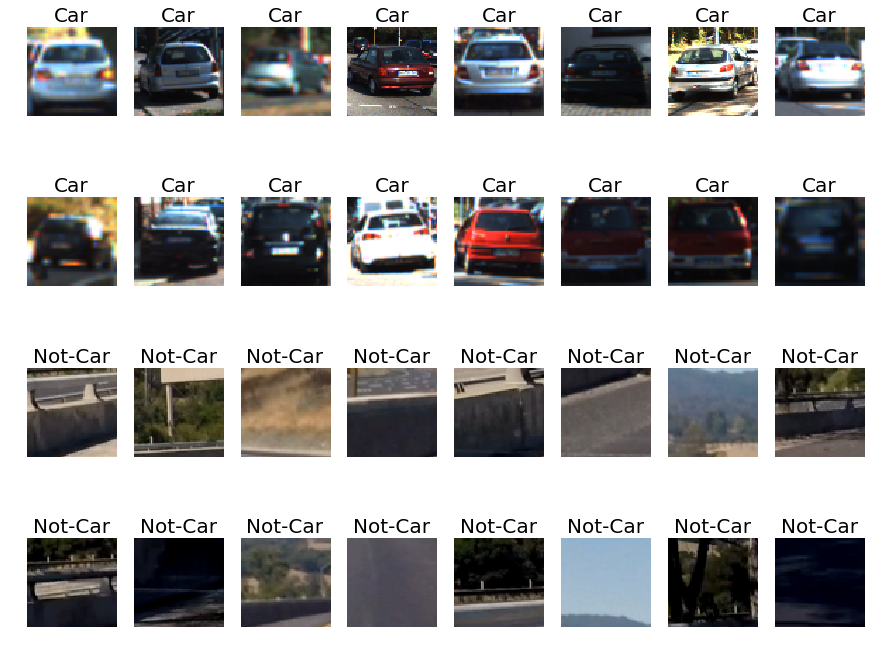

In [3]:
fig, axes = plt.subplots(4,8,figsize=(15,12))
axes = axes.ravel()
for i,ax in enumerate(axes[:16]):
    ax.imshow(mpimg.imread(cars[i]))
    ax.axis('off')
    ax.set_title('Car',fontsize=20)
for i,ax in enumerate(axes[16:]):
    ax.imshow(mpimg.imread(notcars[i]))
    ax.axis('off')
    ax.set_title('Not-Car',fontsize=20)

## Extract features

### Histograms of Color

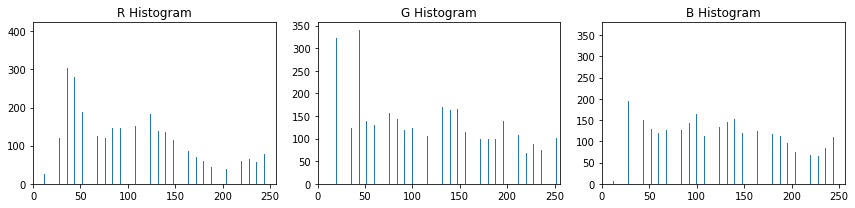

In [4]:
# Read in the image
image = mpimg.imread(cars[0])*255

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0],nbins,bins_range)
    ghist = np.histogram(img[:,:,1],nbins,bins_range)
    bhist = np.histogram(img[:,:,2],nbins,bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features
    
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()

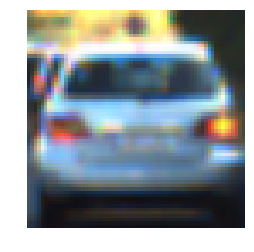

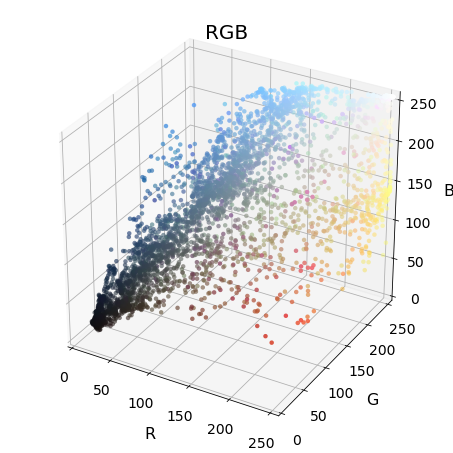

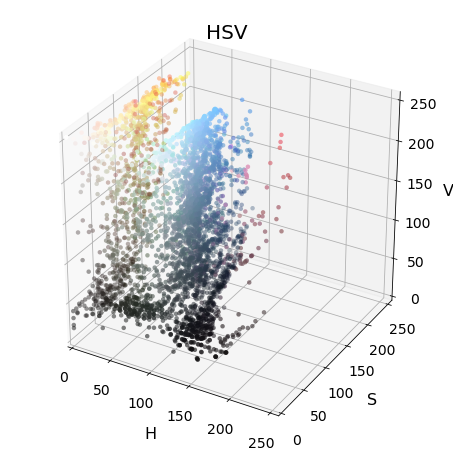

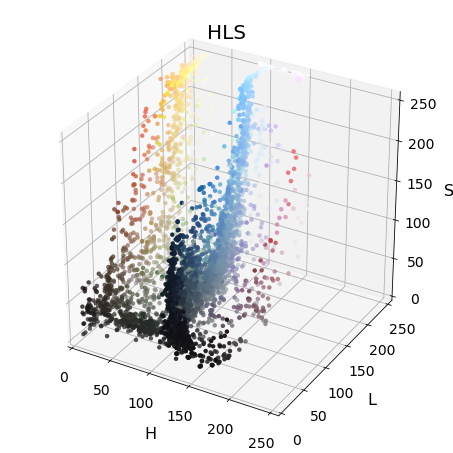

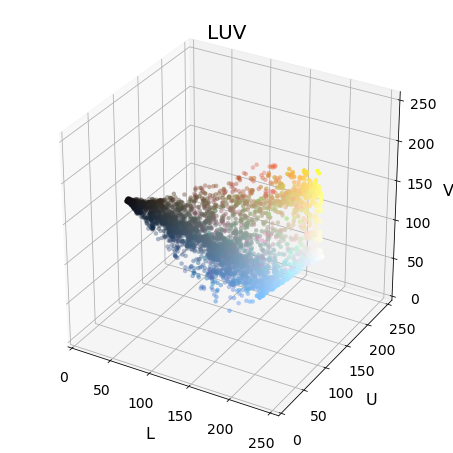

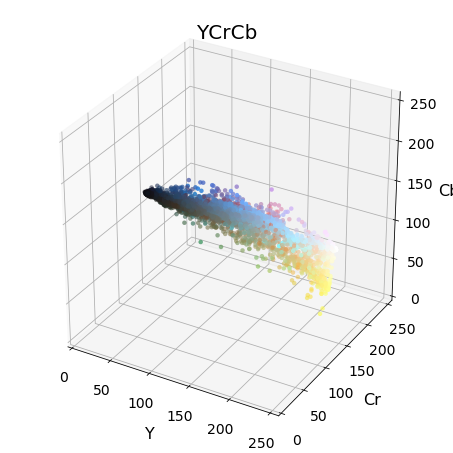

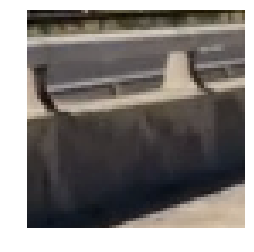

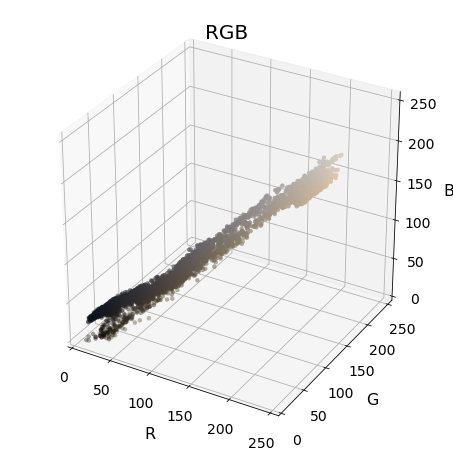

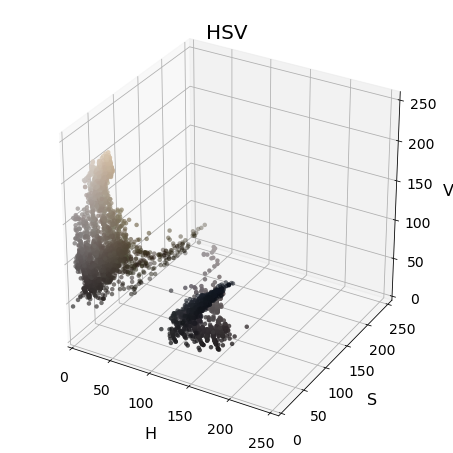

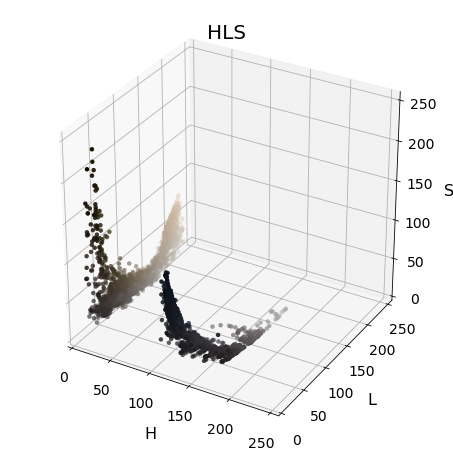

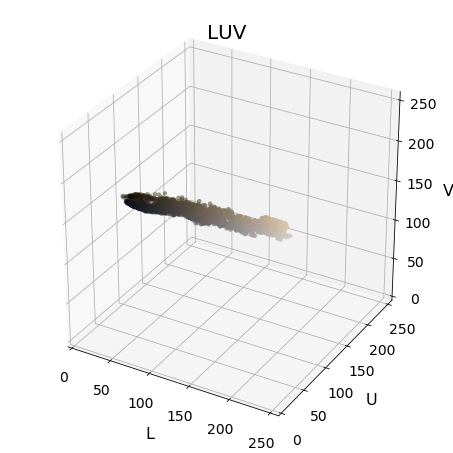

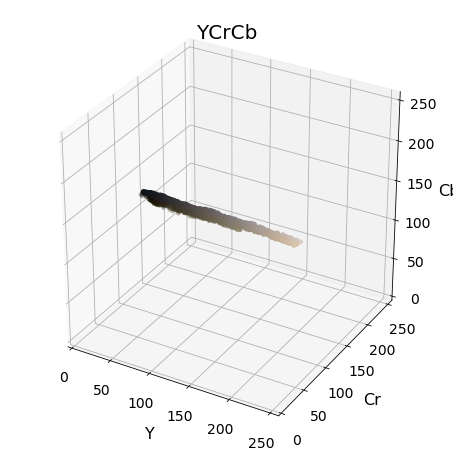

In [5]:
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(6, 6))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

for fname in [cars[0],notcars[0]]:
    # Read a color image
    img = cv2.imread(fname)

    # Select a small fraction of pixels to plot by subsampling it
    scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
    img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

    # Convert subsampled image to desired color space(s)
    img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
    img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
    img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
    img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
    img_small_YCrCb = cv2.cvtColor(img_small, cv2.COLOR_BGR2YCrCb)
    img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

    # Plot and show
    plt.imshow(img_small_RGB)
    plt.axis('off')
    plt.show()
    ax = plot3d(img_small_RGB, img_small_rgb)
    ax.set_title('RGB',fontsize=20)
    plt.show()
    ax = plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
    ax.set_title('HSV',fontsize=20)
    plt.show()
    ax = plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
    ax.set_title('HLS',fontsize=20)
    plt.show()
    ax = plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
    ax.set_title('LUV',fontsize=20)
    plt.show()    
    ax = plot3d(img_small_YCrCb, img_small_rgb, axis_labels=['Y','Cr','Cb'])
    ax.set_title('YCrCb',fontsize=20)
    plt.show()

## Spatial Binning of Color

(-0.5, 31.5, 31.5, -0.5)

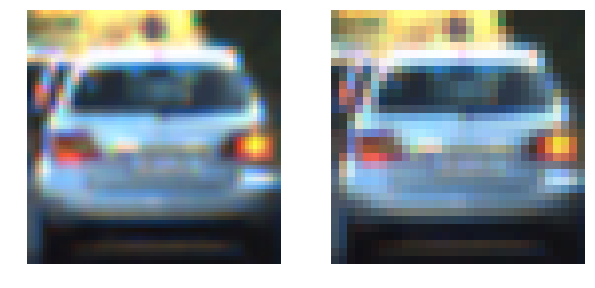

In [6]:
image = mpimg.imread(cars[0])
small_img = cv2.resize(image, (32, 32))
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes = axes.ravel()
axes[0].imshow(image)
axes[0].axis('off')
axes[1].imshow(small_img)
axes[1].axis('off')

## Histogram of Oriented Gradient features

In [7]:
# HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

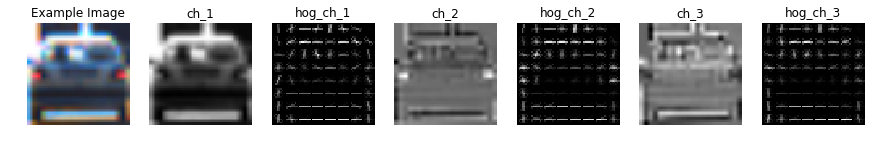

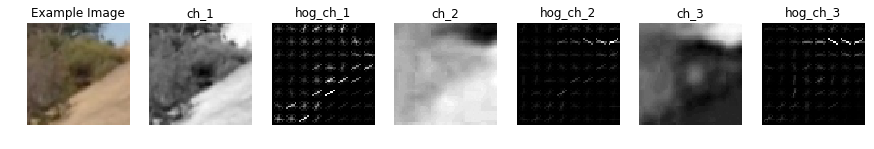

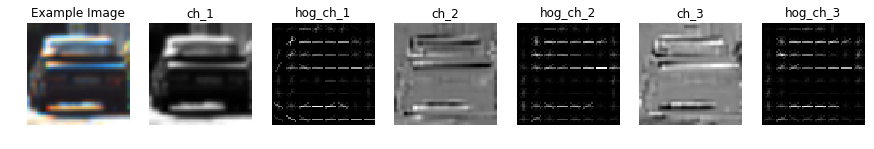

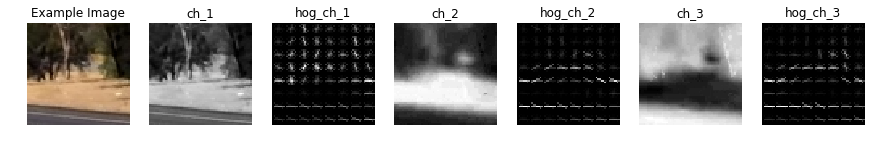

In [16]:
import random
idx = random.randint(0,min(len(cars),len(notcars)))

for fname in [cars[idx],notcars[idx],cars[idx+1],notcars[idx+1]]:
    image = mpimg.imread(fname)
    
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = '0' # Can be 0, 1, 2
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

    features, hog_image_0 = get_hog_features(feature_image[:,:,0], 
                                           orient= orient, 
                            pix_per_cell= pix_per_cell, 
                            cell_per_block= cell_per_block, 
                            vis=True, feature_vec=False)
    features, hog_image_1 = get_hog_features(feature_image[:,:,1], 
                                           orient= orient, 
                            pix_per_cell= pix_per_cell, 
                            cell_per_block= cell_per_block, 
                            vis=True, feature_vec=False)
    features, hog_image_2 = get_hog_features(feature_image[:,:,2], 
                                           orient= orient, 
                            pix_per_cell= pix_per_cell, 
                            cell_per_block= cell_per_block, 
                            vis=True, feature_vec=False)
    image_show = [image, 
                  feature_image[:,:,0], hog_image_0,
                  feature_image[:,:,1], hog_image_1,
                  feature_image[:,:,2], hog_image_2]
    titles = ['Example Image',
              'ch_1','hog_ch_1',
              'ch_2','hog_ch_2',
              'ch_3','hog_ch_3']
    # Plot the examples
    fig,axes = plt.subplots(1,7,figsize=(15,6))
    axes = axes.ravel()
    for i in range(len(axes)):
        axes[i].imshow(image_show[i],'gray')
        axes[i].axis('off')
        axes[i].set_title(titles[i])
